In [2]:
# Cell 1 — Imports & paths

from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# If gensim isn't installed yet: in a separate cell run:
# %pip install gensim

from gensim.models import Word2Vec

# Make plots a bit nicer
plt.style.use("ggplot")

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

INTERACTIONS_PATH = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH = DATA_PROCESSED / "track_metadata.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("INTERACTIONS_PATH:", INTERACTIONS_PATH)
print("TRACK_META_PATH:", TRACK_META_PATH)


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
INTERACTIONS_PATH: C:\Users\Kiera\Music_Recommender\data\processed\interactions.parquet
TRACK_META_PATH: C:\Users\Kiera\Music_Recommender\data\processed\track_metadata.csv


In [3]:
# Cell 2 — Load interactions & metadata

inter = pd.read_parquet(INTERACTIONS_PATH)
track_meta = pd.read_csv(TRACK_META_PATH)

print("Raw interactions shape:", inter.shape)
display(inter.head())

print("\ntrack_metadata.csv shape:", track_meta.shape)
display(track_meta.head())


Raw interactions shape: (6685101, 4)


,pid,track_id,pos,duration_ms
0,0,0UaMYEvWZi0ZqiDOoHU3YI,0,226863
1,0,6I9VzXrHxO9rA9A5euc8Ak,1,198800
2,0,0WqIKmW4BTrj3eJFmnCKMv,2,235933
3,0,1AWQoqb9bSvzTjaLralEkT,3,267266
4,0,1lzr43nnXAijIGYnCT8M8H,4,227600



track_metadata.csv shape: (679889, 7)


,track_id,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,0000uJA4xCdxThagdLkkLR,Heart As Cold As Stone,Cherryholmes,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186
1,00039MgrmLoIzSpuYKurn9,Thas What I Do,Zach Farlow,The Great Escape 2,spotify:artist:2jTojc4rAsOMx6200a8Ah1,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727
2,0005w1bMJ7QAMl6DY98oxa,"Sonata in G Major, BuxWV 271: Allegro -",Dietrich Buxtehude,"Chamber Music: London Baroque - Rosenmuller, J...",spotify:artist:2YfFYZnshSzgfLsKZMM4VL,spotify:album:6oRWciCAwKegipcCc5FlWe,111573
3,0007AYhg2UQbEm88mxu7js,Mandarin Oranges Part 2,Little Simz,E.D.G.E,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000
4,000CTwOSsvRs0bgXlwB64e,Shady World,Celly Cel,The Lost Tapes,spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl,spotify:album:6LOmO9x8uPwlc3gSXZqqi8,155238


In [4]:
# Cell 3 — Basic sanity checks

n_playlists = inter["pid"].nunique()
n_tracks = inter["track_id"].nunique()

print(f"Num playlists in interactions: {n_playlists:,}")
print(f"Num unique tracks in interactions: {n_tracks:,}")

# Sort interactions inside playlists by pos (or duration if you prefer)
inter = inter.sort_values(["pid", "pos"]).reset_index(drop=True)

# Meta sanity
print("\nMetadata coverage of interaction tracks:")
covered = inter["track_id"].isin(track_meta["track_id"]).mean() * 100
print(f"  % of interaction track_ids that have metadata: {covered:.2f}%")


Num playlists in interactions: 100,000
Num unique tracks in interactions: 679,889

Metadata coverage of interaction tracks:
  % of interaction track_ids that have metadata: 100.00%


In [5]:
# Cell 4 — Build playlist sentences (track sequences)

MIN_LEN = 5  # drop very tiny playlists for training stability

playlist_groups = inter.groupby("pid")["track_id"].apply(list)

print("Total playlists:", len(playlist_groups))

playlist_sentences = [tracks for tracks in playlist_groups if len(tracks) >= MIN_LEN]

print(f"Playlists kept (len >= {MIN_LEN}): {len(playlist_sentences)}")
print("Example playlist sentence (first 15 tracks):")
print(playlist_sentences[0][:15])


Total playlists: 100000
Playlists kept (len >= 5): 100000
Example playlist sentence (first 15 tracks):
['0UaMYEvWZi0ZqiDOoHU3YI', '6I9VzXrHxO9rA9A5euc8Ak', '0WqIKmW4BTrj3eJFmnCKMv', '1AWQoqb9bSvzTjaLralEkT', '1lzr43nnXAijIGYnCT8M8H', '0XUfyU2QviPAs6bxSpXYG4', '68vgtRHr7iZHpzGpon6Jlo', '3BxWKCI06eQ5Od8TY2JBeA', '7H6ev70Weq6DdpZyyTmUXk', '2PpruBYCo4H7WOBJ7Q2EwM', '2gam98EZKrF9XuOkU13ApN', '4Y45aqo9QMa57rDsAJv40A', '1HwpWwa6bnqqRhK8agG4RS', '20ORwCJusz4KS2PbTPVNKo', '7k6IzwMGpxnRghE7YosnXT']


In [6]:
# Cell 5 — Train Item2Vec model

# Hyperparameters (tune later if you want)
EMBED_DIM = 64        # size of embedding vector
WINDOW = 20           # how many neighbours left/right to consider
MIN_COUNT = 2         # ignore tracks that appear < 2 times
SG = 1                # 1 = skip-gram, 0 = CBOW
NEGATIVE = 10         # negative samples
EPOCHS = 10

print("Training Word2Vec (Item2Vec) model...")
print(f"  sentences: {len(playlist_sentences):,}")
print(f"  embedding dim: {EMBED_DIM}, window: {WINDOW}, min_count: {MIN_COUNT}")

model = Word2Vec(
    sentences=playlist_sentences,
    vector_size=EMBED_DIM,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=4,
    sg=SG,
    negative=NEGATIVE,
    epochs=EPOCHS,
)

print("Done!")

# Save model so you can reload later without retraining
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

ITEM2VEC_PATH = MODELS_DIR / "item2vec_word2vec.model"
model.save(str(ITEM2VEC_PATH))
print("Saved model to:", ITEM2VEC_PATH)


Training Word2Vec (Item2Vec) model...
  sentences: 100,000
  embedding dim: 64, window: 20, min_count: 2


KeyboardInterrupt: 

In [9]:
# New cell: load trained Item2Vec model from disk (instead of retraining)

from gensim.models import Word2Vec

MODELS_DIR = PROJECT_ROOT / "models"
ITEM2VEC_PATH = MODELS_DIR / "item2vec_word2vec.model"

print("Loading Item2Vec model from:", ITEM2VEC_PATH)
model = Word2Vec.load(str(ITEM2VEC_PATH))
print("Loaded model! Vocab size:", len(model.wv.index_to_key))


Loading Item2Vec model from: C:\Users\Kiera\Music_Recommender\models\item2vec_word2vec.model
Loaded model! Vocab size: 306873


In [10]:
# Cell 6 — Inspect vocabulary & coverage

vocab_tracks = set(model.wv.index_to_key)
print(f"Tracks in Item2Vec vocab (after min_count): {len(vocab_tracks):,}")

inter_tracks = set(inter["track_id"].unique())
meta_tracks = set(track_meta["track_id"].unique())

print(f"Tracks in interactions: {len(inter_tracks):,}")
print(f"Tracks in track_metadata: {len(meta_tracks):,}")

print("\nCoverage:")
print(f"% of interaction tracks in vocab: {len(inter_tracks & vocab_tracks) / len(inter_tracks) * 100:.2f}%")
print(f"% of vocab tracks with metadata: {len(vocab_tracks & meta_tracks) / len(vocab_tracks) * 100:.2f}%")


Tracks in Item2Vec vocab (after min_count): 306,873
Tracks in interactions: 679,889
Tracks in track_metadata: 679,889

Coverage:
% of interaction tracks in vocab: 45.14%
% of vocab tracks with metadata: 100.00%


In [11]:
# Cell 7 — Helper: find track IDs by name substring

# Keep a slim view of metadata for display
meta_simple = (
    track_meta[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates()
    .set_index("track_id")
)

def find_track_ids_by_name(query, top_n=20):
    """
    Simple case-insensitive substring search over track_name and artist_name.
    Returns a small DataFrame of candidate tracks.
    """
    q = query.lower()
    mask = (
        track_meta["track_name"].str.lower().str.contains(q, na=False)
        | track_meta["artist_name"].str.lower().str.contains(q, na=False)
    )
    candidates = (
        track_meta.loc[mask, ["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .head(top_n)
    )
    return candidates

# Example:
display(find_track_ids_by_name("ocean eyes"))


,track_id,track_name,artist_name,album_name
115256,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
246347,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
296150,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
314330,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
359309,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
365109,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
377250,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
556358,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
596823,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)


In [12]:
# Cell 8 — Recommend similar songs via Item2Vec

def describe_tracks(track_ids):
    """
    Given a list/array of track_ids, return a table with names.
    """
    ids = list(track_ids)
    df = meta_simple.loc[meta_simple.index.intersection(ids)].copy()
    df = df.reset_index()
    # Keep the same order as ids
    df = df.set_index("track_id").loc[ids].reset_index()
    return df

def recommend_by_name_item2vec(query, candidate_index=0, top_k=15):
    """
    1) Search for tracks whose name/artist match `query`.
    2) Let you pick one by index (`candidate_index` from the search table).
    3) Use Item2Vec to find the most similar tracks.
    4) Return a DataFrame of recommended tracks + similarity.
    """
    candidates = find_track_ids_by_name(query, top_n=50)
    if candidates.empty:
        print(f"No matches found for query '{query}'")
        return pd.DataFrame()
    
    print("Search results:")
    display(candidates.reset_index(drop=True))

    if candidate_index >= len(candidates):
        raise ValueError(f"candidate_index {candidate_index} out of range (num results={len(candidates)})")
    
    seed_row = candidates.iloc[candidate_index]
    seed_tid = seed_row["track_id"]
    
    print("\nChosen seed track:")
    display(seed_row.to_frame().T)

    if seed_tid not in model.wv:
        print("\n[Item2Vec] Seed track is not in vocab (too rare for MIN_COUNT). "
              "Try another candidate or lower MIN_COUNT and retrain.")
        return pd.DataFrame()

    # Get most similar tracks in embedding space
    sims = model.wv.most_similar(seed_tid, topn=top_k)
    rec_ids = [tid for tid, score in sims]
    rec_scores = [score for tid, score in sims]

    rec_df = describe_tracks(rec_ids)
    rec_df["item2vec_similarity"] = rec_scores
    return rec_df

# Example usage (run and experiment):
# recs = recommend_by_name_item2vec("ocean eyes", candidate_index=2, top_k=15)
# display(recs)


In [13]:
# Cell 9 — Prepare a sample of track embeddings for visualisation

# Take intersection of model vocab and metadata so we can colour by features
vocab_ids = set(model.wv.index_to_key)
meta_ids = set(track_meta["track_id"].unique())
vis_ids = list(vocab_ids & meta_ids)

print(f"Tracks usable for visualisation (in vocab & metadata): {len(vis_ids):,}")

# Sample subset to keep t-SNE manageable
N_TSNE = 3000
if len(vis_ids) > N_TSNE:
    vis_ids_sample = random.sample(vis_ids, N_TSNE)
else:
    vis_ids_sample = vis_ids

print(f"Using {len(vis_ids_sample)} tracks for t-SNE visualisation.")

# Build embedding matrix
emb_matrix = np.vstack([model.wv[tid] for tid in vis_ids_sample])

# Build a small metadata frame for the sampled tracks
vis_meta = (
    track_meta[track_meta["track_id"].isin(vis_ids_sample)]
    .drop_duplicates("track_id")
    .set_index("track_id")
    .loc[vis_ids_sample]  # preserve order
    .reset_index()
)

print("emb_matrix shape:", emb_matrix.shape)
display(vis_meta.head())


Tracks usable for visualisation (in vocab & metadata): 306,873
Using 3000 tracks for t-SNE visualisation.
emb_matrix shape: (3000, 64)


,track_id,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,0y53wnVFD1IhtlwXlL7iyG,Fallin',Regine Velasquez,R2K,spotify:artist:3wNylAjJX1PiCpMKx8Lrfp,spotify:album:1FddNFy6ObxIQg8pIR5HdW,196853
1,1zhw0SSeMnVSLLAKKZzffH,Oklahoma Christmas - feat. Reba,Blake Shelton,"Cheers, it's Christmas.",spotify:artist:1UTPBmNbXNTittyMJrNkvw,spotify:album:4Jk9oJP4aUo6X2XSwTgnBh,208706
2,04CBANKFppVIjXqqY0qodY,Todavia me amas,Aventura,We Broke The Rules,spotify:artist:1qto4hHid1P71emI6Fd8xi,spotify:album:0RIAq5yp636U2iTB0K2Tb6,284908
3,4qp5wgqQXzMOMALjM7sqsi,Pages,There For Tomorrow,There For Tomorrow (Deluxe Edition),spotify:artist:0lYXa6aa87Tz8Jzv1nW4HM,spotify:album:2F931X2I2mB3aBib4CsL5g,211933
4,5jVCcm5rrLJVuthwdvjKPw,I Like Me Better - Cheat Codes Remix,Lauv,I Like Me Better (Remixes),spotify:artist:5JZ7CnR6gTvEMKX4g70Amv,spotify:album:6HgFtRIV14lAAaR0yhtZTV,204000


In [14]:
# Cell 10 — Run t-SNE (this can take a bit of time)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    metric="euclidean",
    init="random",
    random_state=42,
)
X_tsne = tsne.fit_transform(emb_matrix)
print("X_tsne shape:", X_tsne.shape)

vis_meta["tsne_x"] = X_tsne[:, 0]
vis_meta["tsne_y"] = X_tsne[:, 1]


X_tsne shape: (3000, 2)


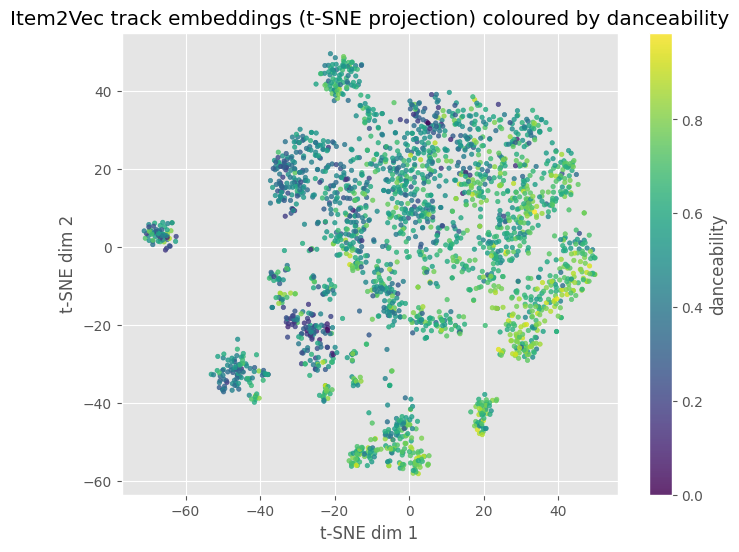

In [15]:
# Cell 11 — Plot t-SNE, coloured by a feature (e.g. danceability)

# Merge in audio features from combined_features (if you want richer colouring).
# If you *don't* have combined_features handy in this notebook, skip the merge.
# Here I'll assume you do:

COMBINED_FEATURES_PATH = DATA_PROCESSED / "combined_features.csv"

cf = pd.read_csv(COMBINED_FEATURES_PATH)
cf_small = cf[["track_id", "danceability", "energy", "valence", "tempo"]].drop_duplicates("track_id")

vis = vis_meta.merge(cf_small, on="track_id", how="left")

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    vis["tsne_x"],
    vis["tsne_y"],
    c=vis["danceability"],
    s=10,
    alpha=0.8,
)
plt.colorbar(sc, label="danceability")
ax.set_title("Item2Vec track embeddings (t-SNE projection) coloured by danceability")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
plt.show()


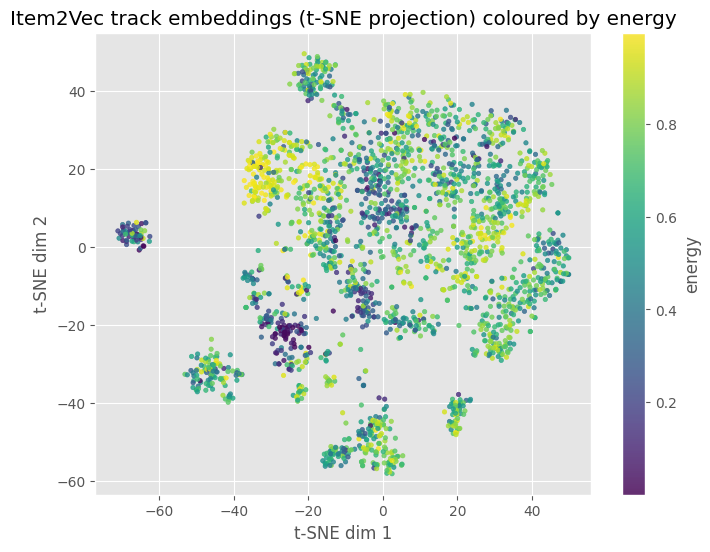

In [16]:
# Cell 12 — Another view: coloured by energy

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    vis["tsne_x"],
    vis["tsne_y"],
    c=vis["energy"],
    s=10,
    alpha=0.8,
)
plt.colorbar(sc, label="energy")
ax.set_title("Item2Vec track embeddings (t-SNE projection) coloured by energy")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
plt.show()


In [17]:
# Cell 13 — Helper to plot a local neighbourhood for a given seed track

def plot_item2vec_neighbourhood(seed_track_id, top_k=15):
    """
    Plot seed track + its Item2Vec neighbours on the t-SNE scatter.
    """
    if seed_track_id not in model.wv:
        print("Seed track not in Item2Vec vocab.")
        return
    
    # nearest neighbours in embedding space
    sims = model.wv.most_similar(seed_track_id, topn=top_k)
    neighbour_ids = [tid for tid, _ in sims]
    neighbour_scores = [score for _, score in sims]
    
    # Ensure these ids exist in our vis DF
    ids_to_plot = [seed_track_id] + neighbour_ids
    mask = vis["track_id"].isin(ids_to_plot)
    sub = vis[mask].copy()
    
    # Label seed vs neighbours
    sub["type"] = np.where(sub["track_id"] == seed_track_id, "seed", "neighbour")
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Plot all background points faintly
    ax.scatter(vis["tsne_x"], vis["tsne_y"], s=5, alpha=0.1, label="others")
    
    # Plot neighbours
    nb = sub[sub["type"] == "neighbour"]
    ax.scatter(nb["tsne_x"], nb["tsne_y"], s=40, alpha=0.8, label="neighbours")
    
    # Plot seed
    sd = sub[sub["type"] == "seed"]
    ax.scatter(sd["tsne_x"], sd["tsne_y"], s=120, marker="*", label="seed", edgecolor="black")
    
    for _, row in sub.iterrows():
        ax.text(
            row["tsne_x"],
            row["tsne_y"],
            row["track_name"][:15],
            fontsize=7,
            alpha=0.9,
        )
    
    ax.set_title("Local Item2Vec neighbourhood (t-SNE space)")
    ax.legend()
    plt.show()

# Example:
# 1) Find a track-id via name
# candidates = find_track_ids_by_name("ocean eyes")
# display(candidates)

# 2) Pick the one you want:
# seed_tid = candidates.iloc[2]["track_id"]
# plot_item2vec_neighbourhood(seed_tid, top_k=15)


In [18]:
# Cell 14 — Rough evaluation: can Item2Vec recover held-out songs?

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

pids = inter["pid"].unique()
SAMPLE_PLAYLISTS = 500
TOP_K = 20

sample_pids = rng.choice(pids, size=min(SAMPLE_PLAYLISTS, len(pids)), replace=False)

hits = 0
total = 0

for pid in sample_pids:
    seq = playlist_groups.loc[pid]
    if len(seq) < 6:
        continue

    # Very simple: treat last track as "held out"
    held_out = seq[-1]
    context_tracks = [tid for tid in seq[:-1] if tid in model.wv]

    if not context_tracks or held_out not in model.wv:
        continue

    # Combine neighbours from some context tracks
    candidate_scores = {}

    for tid in context_tracks[-5:]:  # last few tracks in playlist
        try:
            sims = model.wv.most_similar(tid, topn=TOP_K)
        except KeyError:
            continue
        for nb_tid, score in sims:
            candidate_scores[nb_tid] = max(candidate_scores.get(nb_tid, 0.0), score)

    # Top-K candidates overall
    if not candidate_scores:
        continue

    ranked = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    top_ids = [tid for tid, _ in ranked[:TOP_K]]

    total += 1
    if held_out in top_ids:
        hits += 1

if total > 0:
    hit_rate = hits / total
    print(f"Evaluated on {total} playlists.")
    print(f"HitRate@{TOP_K}: {hit_rate:.4f}")
else:
    print("Not enough playlists passed the filtering for evaluation.")


Evaluated on 468 playlists.
HitRate@20: 0.0919


In [19]:
recs = recommend_by_name_item2vec("hotel room service", candidate_index=1, top_k=15)
display(recs)

recs = recommend_by_name_item2vec("ocean eyes", candidate_index=2, top_k=15)
display(recs)


Search results:


,track_id,track_name,artist_name,album_name
0,0M8AdXqLJKGGXfYgabEX2C,Hotel Room Service - Dj Dizzy Hotel Motel Remix,DJ Dizzy,"Club Traxxx Summer Slammin', Vol. 3"
1,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
2,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
34644,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution


,track_id,track_name,artist_name,album_name,item2vec_similarity
0,4sNUtmv7qaDW7cl855T4Ae,Drop It Like It's Hot,Eclipse,Renee Graziano's Mob Candy Made Men of Hip Hop,0.885828
1,1MxRUN2rYOlLRFfYeLfnwg,Your A Jerk Freestyle,YungReeseRSN,5FlagzDaMixtape,0.881196
2,2QQuKHdhPoAJchgY0HPw96,Right Round - feat. Ke$ha,Flo Rida,R.O.O.T.S. (Route Of Overcoming The Struggle),0.877983
3,13plQdOoWSSXPRUSZc5FuM,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,0.875651
4,3rfhI32Il2hVRKDkuGeeen,Hey Baby (Drop It To the Floor),Pitbull,Planet Pit (Deluxe Version),0.873172
5,2oENJa1T33GJ0w8dC167G4,Fire Burning,Sean Kingston,Tomorrow,0.871828
6,2cZ5ACJfBj2uAXARdHpjAW,The Anthem,Lil Jon,The Boatlift,0.870969
7,0CAfXk7DXMnon4gLudAp7J,Low (feat T-Pain) - Feat T-Pain Album Version,Flo Rida,Mail On Sunday,0.870668
8,68SoU7cLk4xBT7WUewXC08,My Humps - Lil Jon Remix,The Black Eyed Peas,My Humps,0.866251
9,5AyL2kgLtTWEu3qO3B9SqK,Like A G6,Far East Movement,Free Wired,0.860696


Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
3,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
4,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
5,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
6,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
7,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
8,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)



Chosen seed track:


,track_id,track_name,artist_name,album_name
296150,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me


,track_id,track_name,artist_name,album_name,item2vec_similarity
0,2VlLbhGLVJgdOW7kKdWWFc,Six Feet Under,Billie Eilish,Six Feet Under,0.894866
1,0zkZj6g4wGymyMpNQ9xtgs,If We're Reckless (Stay Love),Tatiana Manaois,Speak Now or Forever Hold Your Pain,0.863328
2,31qyVwvvt1YKwwtqIlRcVZ,Bye You,Cailee Rae,Overthinking,0.859468
3,5ljOKMEz0cOqJ91GQIV3Ej,Whispers,Deep Divers,Big Blue Chill,0.852527
4,5HAreAtfnHGMPhRfGfTYju,Lightning (Lost Recording #4),Mark Diamond,War (The Lost Recordings),0.851805
5,4A9bQTr1FVJMlbzPbzC0EV,Please Don't Go,James Harris,Seasons,0.846774
6,10H0Lj9fppehVPCFOCFGak,Paint The Pictures,of Verona,The White Apple,0.843174
7,5Q21hcl3pvWEpDavxzO2oP,Charlotte's Wine - Acoustic,Corey Harper,On the Run Acoustic EP,0.842137
8,3zBGAOwi9SpznWRhn5BSSr,Flower of Life (feat. Kayo Genesis),Evrywhr,Flower of Life (feat. Kayo Genesis),0.839947
9,2c4o4nVVkWGVGO40EZ8OKN,Lost,Rictor,You and Me and Somehow,0.839268


Collected 50000 positive (co-occurring) pairs.
Positive sims mean=0.713, std=0.160
Random sims   mean=0.359, std=0.157


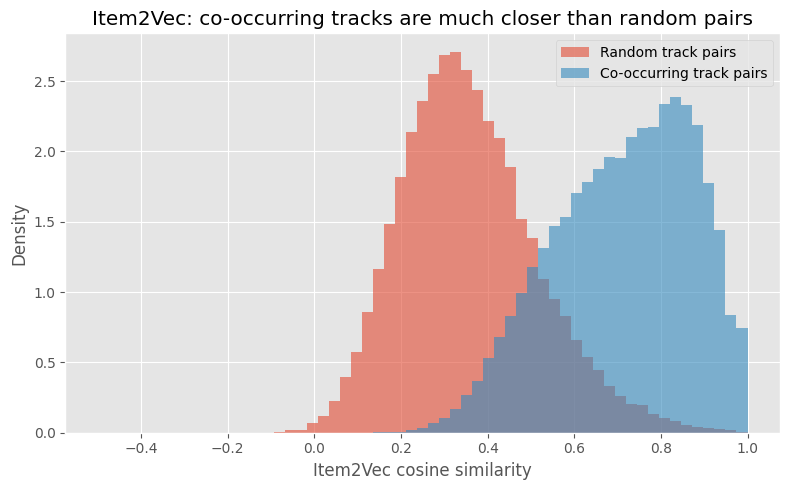

In [20]:
# Cell 15 — Co-occurring vs random similarities in Item2Vec space

import matplotlib.pyplot as plt

# Use normalised vectors for cheap cosine sims
kv = model.wv
normed_vecs = kv.get_normed_vectors()      # shape: (vocab_size, EMBED_DIM)
key_to_idx = kv.key_to_index               # dict: track_id -> row index in normed_vecs

# --- Build positive (co-occurring) and random pairs in *index* space ---

MAX_POS_PAIRS = 50_000
rng = np.random.default_rng(42)

pos_pairs_idx = []   # list of (i, j) indices into normed_vecs

for seq in playlist_sentences:
    # ensure we only keep IDs that are in the vocabulary
    seq_idx = [key_to_idx[tid] for tid in seq if tid in key_to_idx]
    if len(seq_idx) < 2:
        continue

    # adjacent pairs (you could also sample more)
    for a, b in zip(seq_idx[:-1], seq_idx[1:]):
        pos_pairs_idx.append((a, b))
        if len(pos_pairs_idx) >= MAX_POS_PAIRS:
            break
    if len(pos_pairs_idx) >= MAX_POS_PAIRS:
        break

pos_pairs_idx = np.array(pos_pairs_idx, dtype=int)
print(f"Collected {len(pos_pairs_idx)} positive (co-occurring) pairs.")

# Random pairs (same number as positives)
vocab_size = normed_vecs.shape[0]
rand_i = rng.integers(0, vocab_size, size=len(pos_pairs_idx), dtype=int)
rand_j = rng.integers(0, vocab_size, size=len(pos_pairs_idx), dtype=int)
rand_pairs_idx = np.column_stack([rand_i, rand_j])

# --- Compute cosine similarities (dot product of normed vectors) ---

pos_v1 = normed_vecs[pos_pairs_idx[:, 0]]
pos_v2 = normed_vecs[pos_pairs_idx[:, 1]]
pos_sims = np.einsum("ij,ij->i", pos_v1, pos_v2)

rnd_v1 = normed_vecs[rand_pairs_idx[:, 0]]
rnd_v2 = normed_vecs[rand_pairs_idx[:, 1]]
rnd_sims = np.einsum("ij,ij->i", rnd_v1, rnd_v2)

print(f"Positive sims mean={pos_sims.mean():.3f}, std={pos_sims.std():.3f}")
print(f"Random sims   mean={rnd_sims.mean():.3f}, std={rnd_sims.std():.3f}")

# --- Plot distributions ---

plt.figure(figsize=(8, 5))
bins = np.linspace(-0.5, 1.0, 60)
plt.hist(rnd_sims, bins=bins, alpha=0.6, label="Random track pairs", density=True)
plt.hist(pos_sims, bins=bins, alpha=0.6, label="Co-occurring track pairs", density=True)
plt.xlabel("Item2Vec cosine similarity")
plt.ylabel("Density")
plt.title("Item2Vec: co-occurring tracks are much closer than random pairs")
plt.legend()
plt.tight_layout()
plt.show()


Playlists processed: 20000
Offset 1: n=1048463, mean=0.718, std=0.160
Offset 2: n=1029640, mean=0.694, std=0.161
Offset 3: n=1010826, mean=0.682, std=0.160
Offset 4: n=992063, mean=0.674, std=0.159
Offset 5: n=973332, mean=0.668, std=0.158
Offset 6: n=954777, mean=0.663, std=0.158
Offset 7: n=936334, mean=0.659, std=0.157
Offset 8: n=918088, mean=0.656, std=0.157
Offset 9: n=900048, mean=0.653, std=0.157
Offset 10: n=882200, mean=0.650, std=0.157


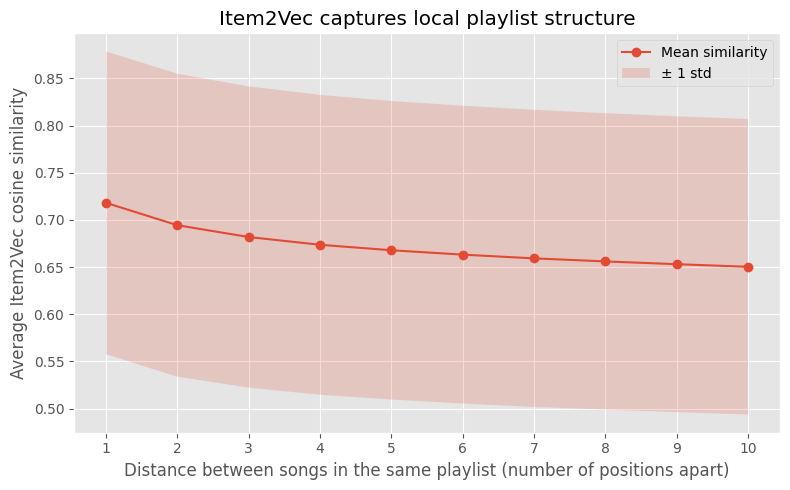

In [21]:
# Cell 16 — Average similarity vs distance within playlists

from collections import defaultdict

MAX_OFFSET = 10      # how far apart songs are in the same playlist
MAX_PLAYLISTS = 20_000

offset_sims = defaultdict(list)
rng = np.random.default_rng(123)

count_playlists = 0

for seq in playlist_sentences:
    # only keep track_ids in vocab
    seq_idx = [key_to_idx[tid] for tid in seq if tid in key_to_idx]
    if len(seq_idx) < 3:
        continue

    # (optional) subsample long playlists to keep runtime sane
    if len(seq_idx) > 100:
        # randomly pick 100 positions
        idx_positions = sorted(rng.choice(len(seq_idx), size=100, replace=False))
    else:
        idx_positions = range(len(seq_idx))

    for i in idx_positions:
        for d in range(1, MAX_OFFSET + 1):
            j = i + d
            if j >= len(seq_idx):
                break
            a = seq_idx[i]
            b = seq_idx[j]
            sim = float(np.dot(normed_vecs[a], normed_vecs[b]))
            offset_sims[d].append(sim)

    count_playlists += 1
    if count_playlists >= MAX_PLAYLISTS:
        break

print(f"Playlists processed: {count_playlists}")
for d in range(1, MAX_OFFSET + 1):
    sims_d = np.array(offset_sims[d])
    print(f"Offset {d}: n={len(sims_d):5d}, mean={sims_d.mean():.3f}, std={sims_d.std():.3f}")

# --- Plot mean ± std vs offset ---

offsets = []
means = []
stds = []

for d in range(1, MAX_OFFSET + 1):
    sims_d = np.array(offset_sims[d])
    if len(sims_d) == 0:
        continue
    offsets.append(d)
    means.append(sims_d.mean())
    stds.append(sims_d.std())

offsets = np.array(offsets)
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(8, 5))
plt.plot(offsets, means, marker="o", label="Mean similarity")
plt.fill_between(offsets, means - stds, means + stds, alpha=0.2, label="± 1 std")
plt.xlabel("Distance between songs in the same playlist (number of positions apart)")
plt.ylabel("Average Item2Vec cosine similarity")
plt.title("Item2Vec captures local playlist structure")
plt.xticks(offsets)
plt.legend()
plt.tight_layout()
plt.show()


Evaluated on 752 playlists.


,K,HitRate
0,1,0.023936
1,5,0.057181
2,10,0.066489
3,20,0.087766
4,50,0.122340


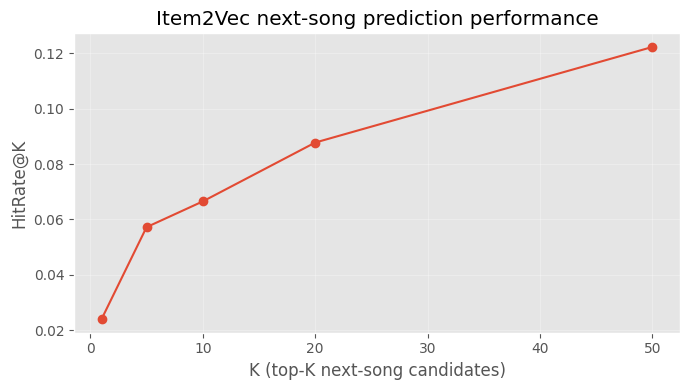

In [22]:
# Cell 17 — HitRate@K curve for Item2Vec (next-song prediction)

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

pids = inter["pid"].unique()
SAMPLE_PLAYLISTS = 800   # increase if it's still fast
Ks = [1, 5, 10, 20, 50]

hits = {K: 0 for K in Ks}
total_eval = 0

for pid in rng.choice(pids, size=min(SAMPLE_PLAYLISTS, len(pids)), replace=False):
    seq = playlist_groups.loc[pid]
    if len(seq) < 6:
        continue

    held_out = seq[-1]
    context_tracks = [tid for tid in seq[:-1] if tid in kv]

    if not context_tracks or held_out not in kv:
        continue

    # Aggregate neighbours from the last few context tracks
    candidate_scores = {}

    for tid in context_tracks[-5:]:
        try:
            sims = kv.most_similar(tid, topn=100)
        except KeyError:
            continue
        for nb_tid, score in sims:
            candidate_scores[nb_tid] = max(candidate_scores.get(nb_tid, 0.0), score)

    # Remove context tracks from candidates if you want a harder task
    for tid in context_tracks:
        candidate_scores.pop(tid, None)

    if not candidate_scores:
        continue

    ranked = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    ranked_ids = [tid for tid, _ in ranked]

    total_eval += 1
    for K in Ks:
        top_k_ids = ranked_ids[:K]
        if held_out in top_k_ids:
            hits[K] += 1

print(f"Evaluated on {total_eval} playlists.")
hit_rates = {K: hits[K] / total_eval for K in Ks}
hit_df = pd.DataFrame({"K": Ks, "HitRate": [hit_rates[K] for K in Ks]})
display(hit_df)

plt.figure(figsize=(7, 4))
plt.plot(hit_df["K"], hit_df["HitRate"], marker="o")
plt.xlabel("K (top-K next-song candidates)")
plt.ylabel("HitRate@K")
plt.title("Item2Vec next-song prediction performance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
# Cell 18 — Simple Item2Vec "analogy" helper

def choose_track_by_name(prompt, top_n=10):
    """
    Interactive-ish helper:
      - shows top_n matches for a query
      - returns the chosen row + track_id
    """
    candidates = find_track_ids_by_name(prompt, top_n=top_n)
    if candidates.empty:
        print(f"No matches found for query '{prompt}'")
        return None, None
    print(f"Matches for '{prompt}':")
    display(candidates.reset_index(drop=True))
    idx = int(input("Enter the index of the track you mean (0-based): "))
    row = candidates.iloc[idx]
    return row, row["track_id"]


def analogue_track(seed_a_id, seed_b_id, seed_c_id, top_k=10):
    """
    Compute: embedding(A) - embedding(B) + embedding(C)
    and find the nearest tracks to that synthetic vector.
    """
    for tid in (seed_a_id, seed_b_id, seed_c_id):
        if tid not in kv:
            raise ValueError(f"Track {tid} not in Item2Vec vocab")

    vec = kv[seed_a_id] - kv[seed_b_id] + kv[seed_c_id]
    sims = kv.similar_by_vector(vec, topn=top_k)

    ids = [tid for tid, score in sims]
    scores = [score for tid, score in sims]
    df = describe_tracks(ids)
    df["analogy_similarity"] = scores
    return df

# Example workflow (run in a notebook cell interactively):
# row_a, id_a = choose_track_by_name("christmas", top_n=10)
# row_b, id_b = choose_track_by_name("pop", top_n=10)
# row_c, id_c = choose_track_by_name("rock", top_n=10)
# analogy_recs = analogue_track(id_a, id_b, id_c, top_k=10)
# display(analogy_recs)


In [24]:
# Example workflow (run in a notebook cell interactively):
row_a, id_a = choose_track_by_name("christmas", top_n=10)
row_b, id_b = choose_track_by_name("pop", top_n=10)
row_c, id_c = choose_track_by_name("rock", top_n=10)
analogy_recs = analogue_track(id_a, id_b, id_c, top_k=10)
display(analogy_recs)

Matches for 'christmas':


,track_id,track_name,artist_name,album_name
0,00591zbq7tnVjtUWwAv2l4,Macarena Christmas - Joy Mix,Los Del Rio,Christmas Party
1,005XVVuSTkz0mg176kfsvn,Have Yourself A Merry Little Christmas,Hem,Peace At Last - EP
2,00HEQPqnVe0kanT85dP3Ef,Sharing Christmas,Ashanti,Ashanti's Christmas
3,00HMEiBMDkbNCHLJL6zqVk,Christmas In Harlem,Kanye West,Christmas In Harlem
4,00Q7nQYFw3vw0XB0yvGKoT,'Twas the Night Before Christmas,Nick Patrick,Christmas At Downton Abbey
5,00R3pAPtYIH4UFqGbFZvOd,Happy Christmas,The Maytals,Trojan Christmas Box Set
6,00TuAlmDT4ILjpoQEIsRlP,Please Come Home For Christmas,Aaron Neville,Aaron Neville's Soulful Christmas
7,00VZVak45oNLxt66ZqydsG,It Feels Like Christmas,The Lettermen,It Feels Like Christmas
8,00cfE4n5LYRRCDZ7CjYBfP,White Christmas - Dreamcatcher Version,Kenny Rogers,Country Christmas
9,00edHBTFClrbFtXutHxzHb,White Christmas,Exit 245,XMAS


Matches for 'pop':


,track_id,track_name,artist_name,album_name
0,0067jQQPclCEKzCeI3qr3v,La Vie En Rose,Iggy Pop,Après
1,008k6AffGTQ9K0BfruEeUI,The Motto - Screwed & Chopped,Pollie Pop,"Pollie Pop: Cigarillo Mini, Vol. 5"
2,00fNdIFKoMxxt8Hnm2kAKL,All Night,Icona Pop,This Is... Icona Pop
3,00lDxPThKQVWP4pAnHbXm8,Bottle Girls Gone Wild (feat. Soup Scudda),Popeye Caution,Bottle Girls Gone Wild
4,00sydAz6PeOxYzwG1dRIPi,Search and Destroy - Iggy Pop Mix,The Stooges,Raw Power
5,00zg6zWC0r8J9gd4OPWpTq,Lies and Cigarettes,Ron Pope,Ron Pope & the Nighthawks
6,01Gu3snVJnQl6lAvdaFEIj,Hustle,Popcaan,Where We Come From
7,01H8xAeIFRAK81axWTTJOe,The Streets of New York,St. Martins Pops Orchestra,Classical Pop Hits
8,01LigwR8Dn9cPqCIGIBqwv,Pop That Middle,Theodis Ealey,I'm the Man You Need
9,01aeybDQwsVMVauMqI0TKU,Motivation - Screwed & Chopped,Pollie Pop,Wet n da Mood 12


Matches for 'rock':


,track_id,track_name,artist_name,album_name
0,001CyR8xqmmpVZFiTZJ5BC,She Knows How To Rock Me,Taj Mahal,TajMo
1,00FEnmNwH45i09TCAr31bN,Wild & Free,A Rocket To The Moon,Wild & Free
2,00Hcx3OfMaC63YfFBenIWy,Rocketman,Vinyl Station,In The Doorway
3,00PXtrulAA6lZfte1lIWXo,Rock The House (You'll Never Be) - Remastered ...,Pressure Drop,"The Tommy Boy Story, Vol. 1"
4,00hTw7P6jPUio5Qgojw38w,Wherever You Go,A Rocket To The Moon,Wild & Free
5,00iVJjZC3fwCC0D0TVV2al,Rockit - Original Mix,J-Trick,Rockit
6,00l0UyOhzwXMF4HC69QCWK,No Hurry,Twinkle Twinkle Little Rock Star,Lullaby Versions of Zac Brown Band
7,00tXkB7eblyLQ2doDckKPX,Rock Of Ages,Chris Rice,Peace Like A River: The Hymns Project
8,00yzUSo4QYR0IP26gVmwT1,God Bless Saturday,Kid Rock,Born Free
9,014S84Cgs1uGmWOIW6V9U9,A Little Soul,Pete Rock,Petestrumentals - 10th Anniversary Expanded & ...


,track_id,track_name,artist_name,album_name,analogy_similarity
0,5BopJ9agE9HhjSbW9kvvwK,Dare to Stand Alone,Zac Love,Efy 2015 Here Am I (Especially for Youth),0.843793
1,2d9JId8pYLjhz8EYQjXH7E,Lord I Would Follow Thee,Jonathan Keith,Heavens View,0.843470
2,1yzGhBqjSTTLHCJibIlnGj,I Just Need You - The Beauty Of Simplicity Alb...,Telecast,The Beauty of Simplicity,0.843272
3,2JCCHeZhTtTUr2WNm3nWe0,In Her Eyes - Live,Josh Groban,Awake Live,0.843182
4,3FW6H3Hp5TplRu7Xs4lgR7,February Song - Live,Josh Groban,Awake Live,0.840827
5,30LAJhGL4bFZpkHwTBZLnc,The Seeker,The Lower Lights,Old Time Religion,0.838810
6,59xUinlK01M8YuBeoOJdqp,The Girl I Am,Jenessa Buttars,Efy 2013 Firm in the Faith (Especially for You...,0.838564
7,5yNi81IVO09gTaflEXyL0Z,Lift Your Eyes,Noelle Bybee,Press Forward,0.838374
8,2V7azyQnDbUlq2WDnfjT6r,Nothing Can Separate Us,Zac Love,Press Forward,0.837491
9,0qN76wmJFCFT12Rvqq2jmO,Come Thou Fount Of Every Blessing,Timothy R. Goodman,Inside Of Me,0.837336
